# Shreyas Patil (USN 01FB15ECS286)
# Shruthi Shankar (USN 01FB15ECS288)
# Siddhanth Vinay (USN 01FB15ECS289)


## Problem Statement: To detect bias in news articles on India-US relations. 


Packages Required: 
- nltk 
- pandas 
- matplotlib
- numpy 
- re (for Regular Expressions)
- wordcloud
- sklearn (for Clustering, silhoutte analysis, tf-idf, Doc2Vec etc)
- gensim 
- vaderSentiment 
    - Install using pip install vaderSentiment
- keras

In [156]:
#Importing the required packages
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [93]:
#Reading the US and India datasets and joining them
df1 = pd.read_csv('dataset_India.csv')
#print("Done")
df2=pd.read_csv('dataset_US.csv')
df=pd.concat([df1,df2])
df.describe()


,Newspaper,Country,Place,Headline,Article
count,139,139,91,139,139
unique,16,3,19,137,139
top,NDTV,India,Washington,"Trump and Modi exchange hugs, herald stronger ...",Poverty-stricken people in India could teach s...
freq,30,83,42,2,1


In [94]:
#Function to tokenize text

from nltk.corpus import stopwords
stopwords=stopwords.words('english')
def tokenize(txt):
    #Tokenizing the text into sentences.
    sent=sent_tokenize(txt)
    #Tokenizing into words
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    text1=tokenizer.tokenize(txt)
    #print(len(words))
    #Removing stopwords
    text1=[str.lower(word) for word in text1]
    filtered_words = [word for word in text1 if word not in stopwords and not word.isdigit()]
    return filtered_words

In [95]:
#Tokenizing and stemming the article
from nltk.stem import PorterStemmer
ps = PorterStemmer()
list=[]
for i in df['Article']:
    tokens=tokenize(i)
    list1=[]
    for w in tokens:
        list1.append(ps.stem(w))
    list.append(list1)
df['Tokens']=list

In [96]:
#Tokenizing and stemming the headline
list=[]
for i in df['Headline']:
    tokens=tokenize(i)
    list1=[]
    for w in tokens:
        list1.append(ps.stem(w))
    list.append(list1)
df['Headline_Tokens']=list
print(df[0:10])
del list

        Newspaper Country           Place  \
0  Times Of India   India       New Delhi   
1  Times Of India   India       New Delhi   
2  Times Of India   India  United Nations   
3  Times Of India   India      Washington   
4  Times Of India   India       New Delhi   
5  Times Of India   India          Panaji   
6  Times Of India   India      Washington   
7  Times Of India   India      Washington   
8  Times Of India   India      Washington   
9  Times Of India   India      Washington   

                                            Headline  \
0  The US on Thursday reaffirmed its commitment t...   
1  After China put up a virtually permanent roadb...   
2  India to UNSC: Focus on eliminating terror saf...   
3  Kenneth Juster sworn in as US ambassador to India   
4  American shutdown: Flights from India to US no...   
5        "India ties are independent of US-Pak ties"   
6  Senate confirms Kenneth Juster as US Ambassado...   
7   US hails India's aid contribution to Afghanistan   


<FreqDist with 6063 samples and 53306 outcomes>


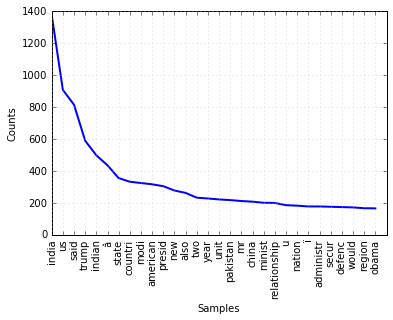

In [97]:
#Building a frequency distribution plot for the most frequent words of the articles
bag_of_words=[]
for i in df['Tokens']:
    bag_of_words.extend(i)

#print(bag_of_words)
fd = nltk.FreqDist(bag_of_words)
print(fd)
fd.plot(30,cumulative=False)

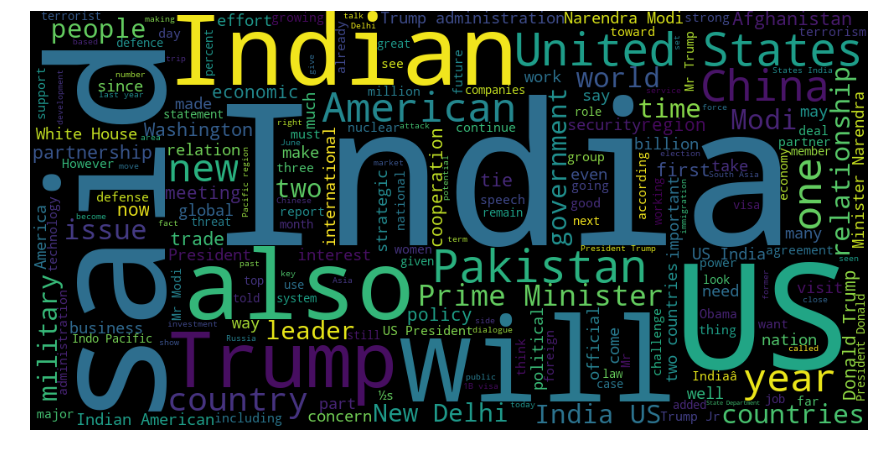

In [98]:
#Building a word cloud for the most frequent words of the articles
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 1000, height = 500,stopwords=stopwords).generate(' '.join(df['Article']))

print(wordcloud)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [99]:
import nltk
from nltk.tokenize import RegexpTokenizer

#function to extract the key phrases
def key_phrase(text):
    lemmatizer = nltk.WordNetLemmatizer()
    #tokenizer1=RegexpTokenizer(sentence_re)
    grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)

    toks = nltk.word_tokenize(text)
    postoks = nltk.tag.pos_tag(toks)
    #print(postoks)
    tree = chunker.parse(postoks)
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    def leaves(tree):
        #Finds NP (nounphrase) leaf nodes of a chunk tree.
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(word):
        #Normalises words to lowercase and stems and lemmatizes it.
        word = word.lower()
        word = lemmatizer.lemmatize(word)
        return word

    def acceptable_word(word):
        #Checks conditions for acceptable word: length, stopword.
        accepted = bool(2 <= len(word) <= 40
            and word.lower() not in stopwords)
        return accepted


    def get_terms(tree):
        for leaf in leaves(tree):
            term = [ normalise(w) for w,t in leaf if acceptable_word(w) ]
            yield term

    terms = get_terms(tree)
    return terms

In [100]:
#Extracting the key phrases from each article
phrases=[]
for i in df['Article']:
    terms=key_phrase(i)
    phrase1=[]
    for term in terms:
        phrase1.extend(term)
    phrases.append(phrase1)
df['Key_Phrases']=phrases
print("Done")

Done


In [101]:
#Due to stemming, US becomes 'u', so, repllacing them with US. America and american are also replaced with US for standardization
temp=df['Key_Phrases']
for i in temp:
    for j in range(len(i)):
        if(i[j]=='u' or i[j]=='america' or i[j]=='american'):
            i[j]='us'
df['Key_Phrases']=temp
print(df['Key_Phrases'])

0     [partner, india, nuclear, supplier, group, mem...
1     [december, indian, us, official, first, time, ...
2     [pakistan, bad, terrorist, india, un, security...
3     [kenneth, juster, us, ambassador, india, vice,...
4     [ripple, effect, united, state, world, flight,...
5     [us, consul, general, mumbai, edgard, kagan, f...
6     [senate, thursday, voice, vote, nomination, ke...
7     [india, great, deal, term, developmental, aid,...
8     [india-us, ministerial, dialogue, defence, ext...
9     [trade, india, us, advocacy, group, bilateral,...
10    [united, state, us, consulate, general, mumbai...
11    [us, nudging, pakistan, india, re-engage, trum...
12    [us, india, contribution, afghanistan, way, ne...
13    [indian, community, us, india, rich, cultural,...
14    [president, donald, trump, fond, country, rela...
15    [north, korea, global, threat, us, thursday, i...
16    [india, us, economic, opportunity, inclusive, ...
17    [india, partner, united, state, peace, sta

In [102]:
#Convert the key phrases to a tf-idf matrix 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(tokenizer=tokenize)
phrases=[]
for i in df['Key_Phrases']:
    phrases.append(' '.join(i))
#print(phrases[0:10])
tokenizer = RegexpTokenizer(r'\w+')
tfs=tfidf.fit_transform(phrases)
df4=pd.DataFrame()
arr1=tfs.toarray()
df5=pd.DataFrame(arr1)
print(df5[0:10])


   0     1         2     3     4     5     6     7     8     9     ...   5436  \
0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
6   0.0   0.0  0.065637   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
7   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   5437  5438  5439  5440  5441  5442  5443  5444  5445  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 

In [103]:
from sklearn.decomposition import TruncatedSVD
#Performing SVD on the sparse matrix into 2000 attributes which accounted
#for 88% in the variation of the data
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
df6=svd.fit_transform(df5)
print(svd.explained_variance_ratio_.sum())  
print(df6)
#Viewing the shape of the data.
df6=pd.DataFrame(df6)
print(df6.shape)

1.0000000000000004
[[ 4.29497344e-01 -2.05657432e-01 -9.06993292e-02 ...  2.31616838e-03
   3.42883770e-05 -8.34883346e-05]
 [ 2.56008615e-01 -6.19789362e-02 -6.82998390e-02 ... -2.44832336e-03
  -1.96754160e-04 -6.40271089e-05]
 [ 2.17349358e-01 -9.61401294e-02 -1.22768200e-01 ... -8.93132745e-05
  -3.80090612e-04 -5.72092476e-05]
 ...
 [ 3.47219628e-01  1.39953488e-01  6.76019932e-02 ...  1.95086518e-01
  -7.25723006e-04  1.67790911e-03]
 [ 3.56649965e-01  1.03322798e-01  4.69812075e-01 ... -5.52479489e-02
  -1.70220445e-03  8.41491607e-04]
 [ 2.87018959e-01  2.29628301e-02  2.37100231e-01 ... -1.08996583e-02
   9.81808581e-04  8.10329753e-05]]
(139, 139)


    cluster_errors  num_clusters  sil_scores
0       118.476100             2    0.027474
1       115.972647             3    0.035515
2       113.320165             4    0.039170
3       111.802040             5    0.030922
4       110.234960             6    0.028279
5       107.530117             7    0.034518
6       106.607648             8    0.031444
7       104.774306             9    0.036016
8       103.188983            10    0.039834
9       102.070625            11    0.035871
10      101.183715            12    0.033377
11       99.636094            13    0.036442
12       98.545500            14    0.037725
13       96.563877            15    0.047177
14       95.364314            16    0.038873
15       94.444535            17    0.039748
16       93.662483            18    0.047740
17       91.874307            19    0.046590
18       91.235544            20    0.043314
19       89.251975            21    0.051639
20       88.185499            22    0.043359
21       8

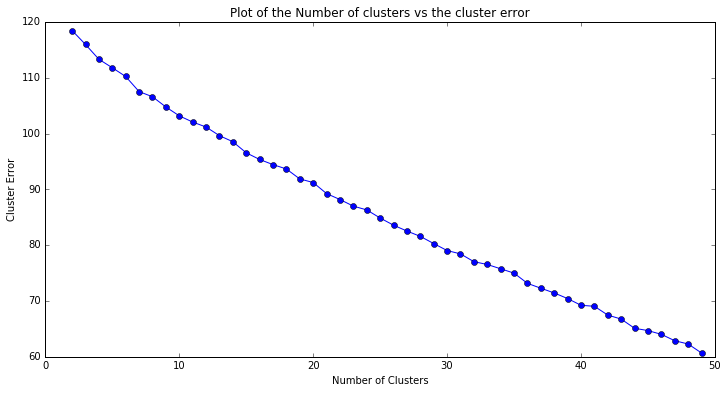

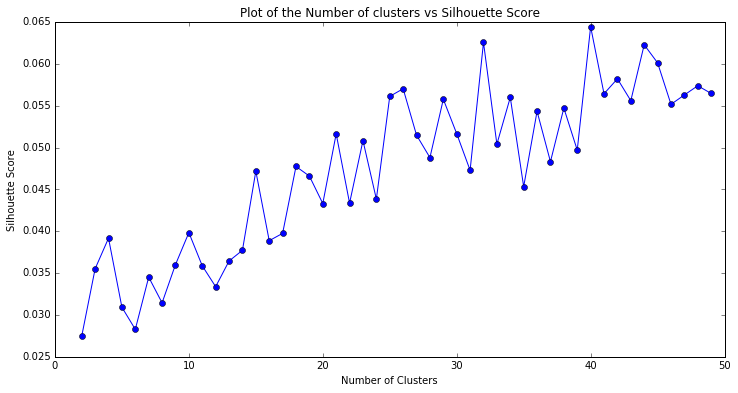

In [104]:
#Experimenting with different vaues of k. Getting the cluster errors, and the silhoutte scores, and adding them to a 
#dataframe. Plotting the elbow curve for the clusters. 


from sklearn import cluster, datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_range = range( 2, 50 )
cluster_errors = []
silhoutte_scores = []

X_scaled = preprocessing.normalize(df6)

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    cluster_labels = clusters.fit_predict( X_scaled )
    #print(cluster_labels)
    cluster_errors.append( clusters.inertia_ )
    #print(cluster_errors)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    #print("The average silhoutte score for k=",num_clusters," is: ",silhoutte_avg)
    silhoutte_scores.append(silhouette_avg)


clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors, "sil_scores":silhoutte_scores} )

print(clusters_df)

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title('Plot of the Number of clusters vs the cluster error')
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')
plt.show()

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.sil_scores, marker = "o" )
plt.title('Plot of the Number of clusters vs Silhouette Score')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

In [105]:
#Performing kmeans on the tf-idf matrix after SVD, with k=30 

from sklearn import cluster, datasets
from sklearn import preprocessing


X_Norm = preprocessing.normalize(df6)
k=30
k_means = cluster.KMeans(n_clusters=k)
res=k_means.fit(X_Norm)
#print(res)
clusters=k_means.labels_[::]
#print(clusters)
import collections
counter=collections.Counter(clusters)
print(counter)
for j in range(k):
    print(j,"\n")
    for i in range(len(clusters)):
        if(clusters[i]==j):
            print(df.iloc[i]['Headline'])
        
    print("\n\n\n")

Counter({9: 14, 6: 12, 3: 9, 17: 9, 0: 8, 1: 7, 18: 7, 10: 6, 13: 6, 20: 6, 7: 5, 11: 5, 22: 5, 28: 5, 5: 4, 2: 3, 4: 3, 16: 3, 23: 3, 24: 3, 29: 3, 8: 2, 12: 2, 19: 2, 27: 2, 14: 1, 15: 1, 21: 1, 25: 1, 26: 1})
0 

As Donald Trump Jr. Drums Up Business in India, Some Ask Whatâ€™s Being Sold
Donald Trump Jr. praises 'spirit' of India's people during promotional trip
Donald Trump Jr. calls Indian media "mild and nice" 
Â Trump Jr. to give foreign policy speech in India.
Eric Trump on addressing gun violence, business in India 
Trump project in India saw $15 million in sales after buyers were offered dinner with Donald Trump Jr.
Trump Jr. to give foreign policy speech while on â€˜unofficialâ€™ business trip to India
Trump Jr. steals spotlight from Canada's Trudeau as India visits coincide




1 

Nikki Haley: Sky is the limit for India-US relationship
Lawmakers Across Parties In The US Ask For Strong Ties With India
US pressure on India to grant more patents on pharma products 'appalling

# Since the clustering based on td-idf didnt give proper clusters to choose an appropriate k-value, we try using Doc2Vec to cluster the similar articles together.
 

In [133]:
#Doc2vec of the articles


#Creating an iterator.
class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc,[self.labels_list[idx]])

#list5 is the labels for the reviews and it is the iterator over the tokens with labels=list5
list5=range(len(df['Tokens']))
it = LabeledLineSentence(df['Tokens'], list5)
print(it)

import gensim
#After multiplce trials with various parameters for the Doc2Vec, choosing size=100 because
#all sizes were giving similar accuracies
model = gensim.models.Doc2Vec(vector_size=1000, min_count=0, alpha=0.025, min_alpha=0.025)
#print("Done")
model.build_vocab(it)
num_epochs=1000
for epoch in range(num_epochs):
    if(epoch%10==0):
        print("EPOCH NUMBER: ",str(epoch+1),"/",num_epochs)
    model.train(it,total_examples=model.corpus_count,epochs=model.epochs)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
total_examples=model.corpus_count
print("no of files read : ",total_examples)

EPOCH NUMBER:  1 / 1000
EPOCH NUMBER:  11 / 1000
EPOCH NUMBER:  21 / 1000
EPOCH NUMBER:  31 / 1000
EPOCH NUMBER:  41 / 1000
EPOCH NUMBER:  51 / 1000
EPOCH NUMBER:  61 / 1000
EPOCH NUMBER:  71 / 1000
EPOCH NUMBER:  81 / 1000
EPOCH NUMBER:  91 / 1000
EPOCH NUMBER:  101 / 1000
EPOCH NUMBER:  111 / 1000
EPOCH NUMBER:  121 / 1000
EPOCH NUMBER:  131 / 1000
EPOCH NUMBER:  141 / 1000
EPOCH NUMBER:  151 / 1000
EPOCH NUMBER:  161 / 1000
EPOCH NUMBER:  171 / 1000
EPOCH NUMBER:  181 / 1000
EPOCH NUMBER:  191 / 1000
EPOCH NUMBER:  201 / 1000
EPOCH NUMBER:  211 / 1000
EPOCH NUMBER:  221 / 1000
EPOCH NUMBER:  231 / 1000
EPOCH NUMBER:  241 / 1000
EPOCH NUMBER:  251 / 1000
EPOCH NUMBER:  261 / 1000
EPOCH NUMBER:  271 / 1000
EPOCH NUMBER:  281 / 1000
EPOCH NUMBER:  291 / 1000
EPOCH NUMBER:  301 / 1000
EPOCH NUMBER:  311 / 1000
EPOCH NUMBER:  321 / 1000
EPOCH NUMBER:  331 / 1000
EPOCH NUMBER:  341 / 1000
EPOCH NUMBER:  351 / 1000
EPOCH NUMBER:  361 / 1000
EPOCH NUMBER:  371 / 1000
EPOCH NUMBER:  381 / 10

In [134]:
from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(model.docvecs,test_size=0)
docvecs=pd.DataFrame(X_train)
#docvecs=docvecs.transpose()
print(docvecs.shape)
#print(docvecs[999])

(139, 1000)


    cluster_errors  num_clusters  sil_scores
0         5.588032             2    0.457173
1         3.757594             3    0.376211
2         2.994080             4    0.320524
3         2.684310             5    0.241149
4         2.412967             6    0.229107
5         2.223228             7    0.228291
6         2.105446             8    0.201689
7         1.972739             9    0.189040
8         1.876989            10    0.197222
9         1.782166            11    0.195237
10        1.688469            12    0.188264
11        1.628084            13    0.187485
12        1.526157            14    0.189088
13        1.469083            15    0.199499
14        1.397316            16    0.198898
15        1.383813            17    0.184955
16        1.330740            18    0.171717
17        1.277228            19    0.186895
18        1.221169            20    0.182912
19        1.178882            21    0.186452
20        1.117921            22    0.180933
21        

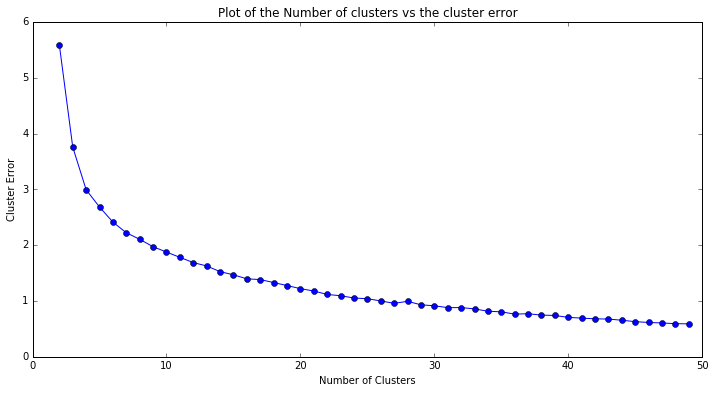

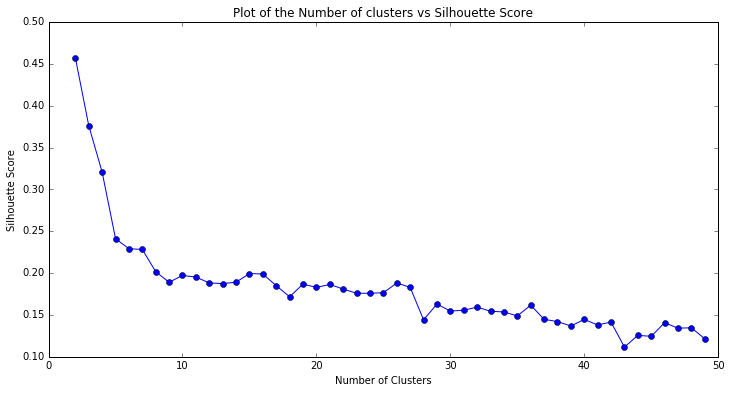

In [135]:
#Experimenting with different vaues of k. Getting the cluster errors, and the silhoutte scores, and adding them to a 
#dataframe. 
#Plotting the elbow curve for the clusters. 
#Plotting the graph of cluster number vs average silhoutte scores


from sklearn import cluster, datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

docvecs_Norm = preprocessing.normalize(docvecs)

cluster_range = range( 2, 50 )
cluster_errors = []
silhoutte_scores = []

X_scaled = docvecs_Norm

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    cluster_labels = clusters.fit_predict( X_scaled )
    #print(cluster_labels)
    cluster_errors.append( clusters.inertia_ )
    #print(cluster_errors)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    #print("The average silhoutte score for k=",num_clusters," is: ",silhoutte_avg)
    silhoutte_scores.append(silhouette_avg)


clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors, "sil_scores":silhoutte_scores} )

print(clusters_df)

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o")
plt.title('Plot of the Number of clusters vs the cluster error')
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')
plt.show()

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.sil_scores, marker = "o" )
plt.title('Plot of the Number of clusters vs Silhouette Score')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

# Based on the elbow curve, we see that the appropriate value of k is between 10 and 20. Since we wanted a greater clustering to ensure more similar articles are together, we narrowed down the range to 15-20. 
# After multiple runs of the code, by analyzing the average silhoutte scores for the clusters formed when k is from 15 to 20, we see that the value 17 has the best silhouute score, and hence choose that as out value of k.

In [136]:
#k means with k=17
import numpy as np
df['Cluster']=np.nan
docvecs_Norm = preprocessing.normalize(docvecs)
#docvecs_Norm=docvecs
k=17
cluster_dict={}
k_means1 = cluster.KMeans(n_clusters=k)
res1=k_means1.fit(docvecs_Norm)
#print(res1)
clusters1=k_means1.labels_[::]
#print(clusters1)
counter1=collections.Counter(clusters1)
print(counter1)


Counter({10: 13, 1: 12, 13: 12, 14: 11, 0: 10, 2: 10, 4: 9, 5: 8, 8: 8, 15: 8, 16: 8, 3: 7, 11: 7, 12: 6, 6: 5, 7: 3, 9: 2})


In [137]:
print(df.head())
Cluster_list= [None] * len(df)
for j in range(k):
    print(j,"\n")
    list1=[]
    list1.append([])
    for i in range(len(clusters1)):
        if(clusters1[i]==j):
            print(df.iloc[i]['Country'],":  ",df.iloc[i]['Headline'])
            Cluster_list[i]=j
            #print("Before assigning: ",df.iloc[i]['Cluster'])
            #print("After Assigning: ",df.iloc[i]['Cluster'])
            list1.append(df.iloc[i]['Headline'])
            list1[0].append(df.iloc[i]['Country'])
    #print(list1)
    cluster_dict[j]=list1
    print("\n\n\n")

#df['Cluster'] = Cluster_list    
df.head()


        Newspaper Country           Place  \
0  Times Of India   India       New Delhi   
1  Times Of India   India       New Delhi   
2  Times Of India   India  United Nations   
3  Times Of India   India      Washington   
4  Times Of India   India       New Delhi   

                                            Headline  \
0  The US on Thursday reaffirmed its commitment t...   
1  After China put up a virtually permanent roadb...   
2  India to UNSC: Focus on eliminating terror saf...   
3  Kenneth Juster sworn in as US ambassador to India   
4  American shutdown: Flights from India to US no...   

                                             Article  \
0  "We are working with partners to secure India'...   
1  In December, Indian and US officials will meet...   
2  Pakistan needs to change its "mindset" of diff...   
3  Kenneth Juster has been sworn in as the US amb...   
4  Despite the ripple effect of the United States...   

                                              Tokens  \

,Newspaper,Country,Place,Headline,Article,Tokens,Headline_Tokens,Key_Phrases,Cluster,Category
0,Times Of India,India,New Delhi,The US on Thursday reaffirmed its commitment t...,"""We are working with partners to secure India'...","[work, partner, secur, india, nuclear, supplie...","[us, thursday, reaffirm, commit, help, india, ...","[partner, india, nuclear, supplier, group, mem...",NaN,1
1,Times Of India,India,New Delhi,After China put up a virtually permanent roadb...,"In December, Indian and US officials will meet...","[decemb, indian, us, offici, meet, first, time...","[china, put, virtual, perman, roadblock, prosc...","[december, indian, us, official, first, time, ...",NaN,1
2,Times Of India,India,United Nations,India to UNSC: Focus on eliminating terror saf...,"Pakistan needs to change its ""mindset"" of diff...","[pakistan, need, chang, mindset, differenti, g...","[india, unsc, focu, elimin, terror, safe, have...","[pakistan, bad, terrorist, india, un, security...",NaN,1
3,Times Of India,India,Washington,Kenneth Juster sworn in as US ambassador to India,Kenneth Juster has been sworn in as the US amb...,"[kenneth, juster, sworn, us, ambassador, india...","[kenneth, juster, sworn, us, ambassador, india]","[kenneth, juster, us, ambassador, india, vice,...",NaN,1
4,Times Of India,India,New Delhi,American shutdown: Flights from India to US no...,Despite the ripple effect of the United States...,"[despit, rippl, effect, unit, state, shut, acr...","[american, shutdown, flight, india, us, affect]","[ripple, effect, united, state, world, flight,...",NaN,1


For n_clusters = 17 The average silhouette_score is : 0.19619774539095966


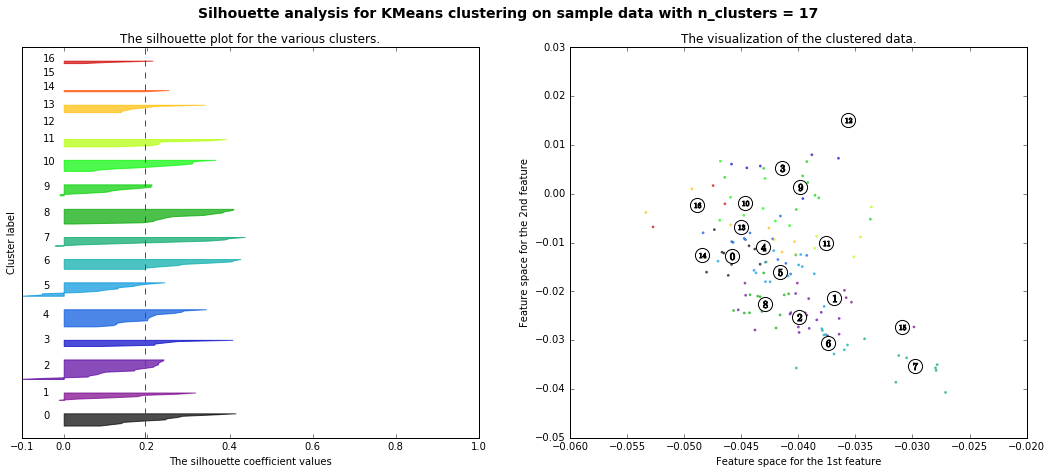

In [138]:
#Plotting a silhoutte plot for k=17

import matplotlib.cm as cm
import numpy as np
cluster_range = range(17,18)
for n_clusters in cluster_range:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( X_scaled )

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

    plt.show()

# We assign clusters to the articles in the dataframe, and for any article belonging to a cluster which has articles only from Indian or only from non Indian countries, we assign all of those articles to a common cluster 100.

In [139]:
# Going through the different clusters formed, and if the clusters have articles from the same country, remove them
# and add them to a common cluster 100. 

print(cluster_dict)
list1=[]
list1.append([])
single_clusters=[]

for k,v in cluster_dict.items():
    print(k)
    print(cluster_dict[k])
    print(len(cluster_dict[k]))
    country_set=set(cluster_dict[k][0])
    print(country_set)
    print(len(country_set))
    if "India" not in country_set:
        single_clusters.append(k)
    elif "India" in country_set and len(country_set)==1:
        single_clusters.append(k)
    
    
print("\n\n\n\n")
#print(list1)
print(single_clusters)
#cluster_dict[100]=list1

for i in range(len(Cluster_list)):
    if Cluster_list[i] in single_clusters:
        Cluster_list[i] = 100

print(Cluster_list)

df['Cluster'] = Cluster_list
df.head()

{0: [['India', 'India', 'India', 'India', 'India', 'America', 'America', 'America', 'America', 'America'], '"India ties are independent of US-Pak ties"', 'Looking Forward To Donald Trump-Prime Minister Narendra Modi First Meeting: White House', "Rex Tillerson Says US Is 'Reliable Partner' For India, Takes Dig At China", 'Building a durable US-India partnership', 'How Indian Americans have failed to make a strong impact on US mainstream culture \n\n', 'Obama Nominates Richard Verma as Next Ambassador to India', 'Trump and Modi exchange hugs, herald stronger US-India ties', 'With Trump Set to Meet Narendra Modi, Many U.S. Indians Are Hopeful', "Won't Accept Interference From US In India And Pakistan's Matters, Says BJP", 'Donald Trump Jr. Retreats From Foreign Policy on India Trip'], 1: [['India', 'India', 'India', 'India', 'India', 'India', 'India', 'India', 'America', 'America', 'America', 'America'], 'After China put up a virtually permanent roadblock for proscribing Masood Azhar by t

,Newspaper,Country,Place,Headline,Article,Tokens,Headline_Tokens,Key_Phrases,Cluster,Category
0,Times Of India,India,New Delhi,The US on Thursday reaffirmed its commitment t...,"""We are working with partners to secure India'...","[work, partner, secur, india, nuclear, supplie...","[us, thursday, reaffirm, commit, help, india, ...","[partner, india, nuclear, supplier, group, mem...",6,1
1,Times Of India,India,New Delhi,After China put up a virtually permanent roadb...,"In December, Indian and US officials will meet...","[decemb, indian, us, offici, meet, first, time...","[china, put, virtual, perman, roadblock, prosc...","[december, indian, us, official, first, time, ...",1,1
2,Times Of India,India,United Nations,India to UNSC: Focus on eliminating terror saf...,"Pakistan needs to change its ""mindset"" of diff...","[pakistan, need, chang, mindset, differenti, g...","[india, unsc, focu, elimin, terror, safe, have...","[pakistan, bad, terrorist, india, un, security...",12,1
3,Times Of India,India,Washington,Kenneth Juster sworn in as US ambassador to India,Kenneth Juster has been sworn in as the US amb...,"[kenneth, juster, sworn, us, ambassador, india...","[kenneth, juster, sworn, us, ambassador, india]","[kenneth, juster, us, ambassador, india, vice,...",14,1
4,Times Of India,India,New Delhi,American shutdown: Flights from India to US no...,Despite the ripple effect of the United States...,"[despit, rippl, effect, unit, state, shut, acr...","[american, shutdown, flight, india, us, affect]","[ripple, effect, united, state, world, flight,...",1,1


# The NRC emotion lexicon model where sentiments are extracted is used, and is already previously trained, and is stored in the file emotions.pkl to avoid the time consuming training everytime. This data is loaded from the file before it is used. 

In [140]:
#Loading the NRC-emotion-lexicon
'''
nrc_lex = pd.read_csv( "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt",sep='\t', names=['word','emotion','association'])
#nrc_lex.head()
print ("\n NRC Emotion lexicon loaded...")
col=['anger','fear','anticipation','trust','surprise','joy','sadness','disgust']
emotions=pd.DataFrame(columns=col)
'''
print("Run Before")

Run Before


In [141]:
'''
#For each review, using the frequency distribution of it's tokens, store the list of the 8 emotion attribute values
#in list and the list of emotion words of that review in emotion_words
emotion_list=[]
emotion_words=[]
ctr=1
for i in df['Tokens']:
    global ctr
    print(ctr)
    anger = 0
    fear = 0
    anticipation = 0
    trust = 0
    surprise = 0
    sadness = 0
    joy = 0
    disgust = 0
    list1=[]
    emotion_word=[]
    freq_dist=nltk.FreqDist(i)
    for w1,w2 in freq_dist.items():
        if nrc_lex['word'].str.contains(w1).any():
            #print ("Found",w1)
            #print w1,w2
            #Change here ..every line is getting printed
            #print (nrc_lex.loc[nrc_lex['word'] == w1])
            anger_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='anger'].index.tolist()
            if len(anger_list) == 1:
                anger += w2*int(nrc_lex.iloc[int(anger_list[0])]['association'])
            fear_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='fear'].index.tolist()
            if len(fear_list) == 1:
                fear += w2*int(nrc_lex.iloc[int(fear_list[0])]['association'])
            anticipation_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='anticipation'].index.tolist()
            if len(anticipation_list) == 1:
                anticipation += w2*int(nrc_lex.iloc[int(anticipation_list[0])]['association'])
            trust_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='trust'].index.tolist()
            if len(trust_list) == 1:
                trust += w2*int(nrc_lex.iloc[int(trust_list[0])]['association'])
            surprise_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='surprise'].index.tolist()
            if len(surprise_list) == 1:
                surprise += w2*int(nrc_lex.iloc[int(surprise_list[0])]['association'])
            sadness_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='sadness'].index.tolist()
            if len(sadness_list) == 1:
                sadness += w2*int(nrc_lex.iloc[int(sadness_list[0])]['association'])
            joy_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='joy'].index.tolist()
            if len(joy_list) == 1:
                joy += w2*int(nrc_lex.iloc[int(joy_list[0])]['association'])
            disgust_list = nrc_lex[nrc_lex['word']==w1][nrc_lex['emotion']=='disgust'].index.tolist()
            if len(disgust_list) == 1:
                disgust += w2*int(nrc_lex.iloc[int(disgust_list[0])]['association'])
            #print ("emotion word: ", w1)
            if w1 not in emotion_word:
                emotion_word.append(w1)
    list1=[anger,fear,anticipation,trust,surprise,joy,sadness,disgust]
    emotion_list.append(list1)
    emotion_words.append(emotion_word)
    ctr+=1
'''
print("Run Before")

Run Before


# The emotions dataframe is loaded from the emotions.pkl file is and a neural network is trained and used to classify whether an article belongs to an Indian Newspaper or not based on this emotion sentiment dataframe based on the NRC emotion lexicon. This is done as a pre cursor just to see if a classifier can predict with some accuracy whether the article can be classified using the sentiment scores to see if there is a difference in emotions between the Indian and Non Indian articles, hence indicating some bias.  

In [142]:
#emotion_list=pd.DataFrame(emotion_list)
#emotion_list.to_pickle('emotions.pkl') 
emotion_list = pd.read_pickle('emotions.pkl')
#df = df.sample(frac=1).reset_index(drop=True)
category=[]
for i in df['Country']:
    if i=='India':
        category.append(1)
    else:
        category.append(0)
df['Category']=category

#for i in range(100):
#   print(df.iloc[i]['Country']," ",category[i])
print("done")

done


In [143]:
emotion_list['Category']=category
emotion_list = emotion_list.sample(frac=1).reset_index(drop=True)
#print(emotion_list[0:10])
categories=emotion_list['Category']
emotion_list=emotion_list.drop(columns=['Category'])
print(emotion_list[0:10])

    0   1   2   3   4   5   6  7
0   0   1   1   5   5   1   0  0
1   7  12  20  36  16   8   9  3
2   6   9  25  52   1   5   8  1
3   0   0   5  16   2   1   0  0
4  11   6  11  10   7   2   5  3
5   1   2   7  13  10   2   1  0
6  17  24  34  98  26  23  14  7
7   1   5   3   5   1   3   0  2
8   2   2  14  21   6  11   2  1
9  12  12  22  33   8  15   7  2


In [144]:
# Building the model 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy
from numpy import array

model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
# Compile model
epochs = 500
learning_rate = 3
decay_rate = learning_rate / epochs
sgd = SGD(lr=learning_rate, momentum=0.2, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#print(categories)
print(emotion_list)
emotion_list = array(emotion_list)
categories = array(categories)
# Fit the model. We manually provide the train and test partition
history=model.fit(emotion_list,categories,validation_split=0.25,epochs=150, batch_size=8, verbose=2)
print(history.history.keys())

      0   1   2   3   4   5   6   7
0     0   1   1   5   5   1   0   0
1     7  12  20  36  16   8   9   3
2     6   9  25  52   1   5   8   1
3     0   0   5  16   2   1   0   0
4    11   6  11  10   7   2   5   3
5     1   2   7  13  10   2   1   0
6    17  24  34  98  26  23  14   7
7     1   5   3   5   1   3   0   2
8     2   2  14  21   6  11   2   1
9    12  12  22  33   8  15   7   2
10    5   8  17  25  27  11   6   1
11    4  13  20  30   2  14   4   1
12   19  30  22  45   9  28  18  16
13    3   3   6   6   3   5   1   1
14    2   8  20  34  15  12   4   4
15   13  13  31  60  32  25   9   8
16   15  16   8  17   1   2   5   1
17    3   5   6  13   1   2   5   0
18    3   4   6   8   7   5   1   0
19   15  19  17  21  14  11  12   4
20    2   3  12  10   2   7   1   2
21    6   4   7  17   6   4   9   5
22    3   5   7  12   6   6   4   3
23    2   8  19  33  13  12   4   4
24    1   1   8  10   4   5   2   1
25    5   9  12  21  10  10   5   4
26    4   4   5  15   2   3 

# Hence, since we are getting accuracies near 60%, there is some indicator that the classifier is able to classify the articles based on the emotions and this is an indicator of bias.

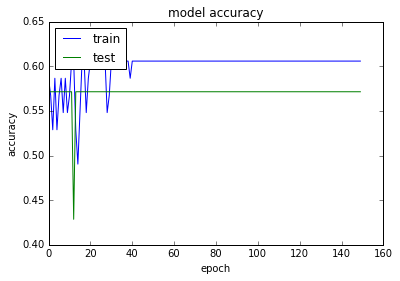

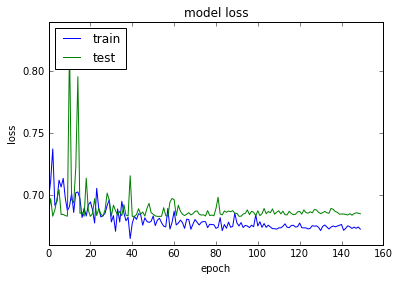

In [145]:
# Plotting the model accuracies and model loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Vader sentiment analysis is useful for clustering sentences and it takes as input a sentence and it returns a positive sentiment score, a negative sentiment score, a neutral sentiment score, all in the range 0-1, which we consider for analysis. For every article, we take an average of these scores of all the sentences in the article to be the score for the article. Then, for every cluster, we take the three average sentiment scores for the Indian articles and the three average sentiment scores for the non Indian articles.

In [159]:
#Sentiment analysis of each article
# This is done by going through each sentence of the article, and getting its Positive, Negative and Neutral sentiment score, 
# and averaging them to get the Positive, Negative and Neutral sentiment scores for the whole article. 
# Then the average cluster score is calculated, for Indian and Non-Indian articles, all of which is stored in the 
# dictionary avg_cluster_scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import scipy

analyser = SentimentIntensityAnalyzer()

def sent_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt
    

avg_cluster_scores={}

for clust_no in range(101):
    cluster_sentiments_pos=[]
    cluster_sentiments_neg=[]
    cluster_sentiments_neut=[]
    india_pos=[]
    india_neg=[]
    india_neut=[]
    not_india_pos=[]
    not_india_neg=[]
    not_india_neut=[]
    cluster_dict={}
    india_dict={}
    not_india_dict={}
    total_dict={}
    for j in range(df.shape[0]):
        if(df.iloc[j]['Cluster'] == clust_no):
            print(clust_no)
            print('------>',df.iloc[j]['Country'],'<-----')
            pos=0
            neg=0
            neut=0
            #print(df.iloc[j]['Article'])  #READ THE ARTICLE TO FIND OUT BIAS
            article_sentences = nltk.sent_tokenize(df.iloc[j]['Article'])
            for i in article_sentences:
                score = sent_scores(i)
                #print(score)
                pos += score['pos']
                neg += score['neg']
                neut += score['neu']
            length = len(article_sentences)
            pos = pos/length
            neg = neg/length
            neut = neut/length
            print("Pos: ",pos)
            print("Neg: ",neg)
            print("Neut: ",neut)
            cluster_sentiments_pos.append(pos)
            cluster_sentiments_neg.append(neg)
            cluster_sentiments_neut.append(neut)
            if df.iloc[j]['Country'] == "India":
                india_pos.append(pos)
                india_neg.append(neg)
                india_neut.append(neut)
            else:
                not_india_pos.append(pos)
                not_india_neg.append(neg)
                not_india_neut.append(neut)
    if cluster_sentiments_pos:
        #print(cluster_sentiments_pos)
        #print(cluster_sentiments_neg)
        #print(cluster_sentiments_neut)    
        cluster_dict['pos'] = np.mean(cluster_sentiments_pos)
        cluster_dict['neg'] = np.mean(cluster_sentiments_neg)
        cluster_dict['neut'] = np.mean(cluster_sentiments_neut)
        india_dict['pos'] = np.mean(india_pos)
        india_dict['neg'] = np.mean(india_neg)
        india_dict['neut'] = np.mean(india_neut)
        not_india_dict['pos'] = np.mean(not_india_pos)
        not_india_dict['neg'] = np.mean(not_india_neg)
        not_india_dict['neut'] = np.mean(not_india_neut)
        total_dict['India']=india_dict
        total_dict['Not_India']=not_india_dict
        total_dict['Total']=cluster_dict
        avg_cluster_scores[clust_no] = total_dict
        
    #print(india)
    #print(not_india)

        
print("\n\n\n\n")
#print(avg_cluster_scores)
print("Average Cluster Scores\n\n")
for k,v in avg_cluster_scores.items():
    print(k)
    print(v)
    print("\n\n")

    

0
------> India <-----
Pos:  0.078
Neg:  0.08175
Neut:  0.8402499999999999
0
------> India <-----
Pos:  0.08571428571428573
Neg:  0.018142857142857145
Neut:  0.896
0
------> India <-----
Pos:  0.15813333333333332
Neg:  0.047466666666666664
Neut:  0.7944
0
------> India <-----
Pos:  0.22055263157894736
Neg:  0.01786842105263158
Neut:  0.761578947368421
0
------> India <-----
Pos:  0.077
Neg:  0.025976744186046508
Neut:  0.8970232558139536
0
------> America <-----
Pos:  0.052888888888888895
Neg:  0.08144444444444446
Neut:  0.8656666666666666
0
------> America <-----
Pos:  0.0940857142857143
Neg:  0.08288571428571428
Neut:  0.823
0
------> America <-----
Pos:  0.09038095238095238
Neg:  0.03271428571428572
Neut:  0.8769285714285713
0
------> America <-----
Pos:  0.0776
Neg:  0.0656
Neut:  0.8565999999999999
0
------> America <-----
Pos:  0.09095000000000002
Neg:  0.046875
Neut:  0.8622000000000002
1
------> India <-----
Pos:  0.06956249999999999
Neg:  0.1980625
Neut:  0.7325625
1
------> I

# As we can see, the positive and negative scores are in a low range (lesser than 0.2) where as the neutral scores are all above 0.8. This indicates that the media tends to report articles as diplomatically as possible and whatever analysis we do is restricted to the small positive and negative scores where the true opinion of the article is concealed. 

In [147]:
#The cluster scores are extracted from he dictionary, in order to plot them.

#print(avg_cluster_scores)
try:
    avg_cluster_scores[18] = avg_cluster_scores.pop(100)
except KeyError:
    print("No cluster with only Indian or Non Indian Countries")

keys = list(avg_cluster_scores.keys())
india_pos=[]
india_neg=[]
not_india_pos=[]
not_india_neg=[]
#print(keys)
for k in keys:
    india_pos.append(avg_cluster_scores[k]["India"]["pos"])
    india_neg.append(avg_cluster_scores[k]["India"]["neg"])
    not_india_pos.append(avg_cluster_scores[k]["Not_India"]["pos"])
    not_india_neg.append(avg_cluster_scores[k]["Not_India"]["neg"])
    
print(india_pos)
print(india_neg)
print(not_india_pos)
print(not_india_neg)



No cluster with only Indian or Non Indian Countries
[0.12388005012531327, 0.09044572916666666, 0.13471166666666667, 0.10093108974358976, 0.10990238678090576, 0.13464386551424223, 0.1245, 0.11290909090909093, 0.12338068181818182, 0.11490909090909093, 0.09523334002417334, 0.10580518518518518, 0.08272296650717703, 0.11467857172186441, 0.08572552795031056, 0.12210942768411713, 0.11841428571428571]
[0.03824093780964038, 0.05452473710317461, 0.019276666666666668, 0.03171714743589744, 0.02887056983544132, 0.03578533105022832, 0.03472727272727273, 0.06447954545454546, 0.044654701910408434, 0.0, 0.037246882931882934, 0.03247683333333333, 0.07317543859649124, 0.047847984197374446, 0.04611154244306418, 0.04593470866607512, 0.03466388888888889]
[0.08118111111111112, 0.07606162587412589, 0.09328043365399298, 0.07074120809614168, 0.1339060302936311, 0.10948888888888889, 0.0888459595959596, 0.10663333333333332, 0.08431251493794455, 0.05223076923076924, 0.12414773773923446, 0.11801447368421054, 0.0860

# First, for both the positive and negative scores, for each cluster, we plot the average positive/negative score for Indian articles and the average positive/negative score for non-Indian articles. 

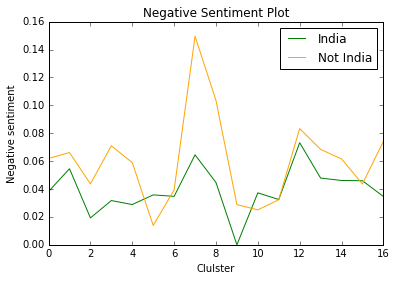

In [148]:
#Plotting the negative sentiments

import matplotlib.pyplot as plt

plt.plot(keys, india_neg, color='g',label="India")
plt.plot(keys, not_india_neg, color='orange',label="Not India")
plt.xlabel('Clulster')
plt.ylabel('Negative sentiment')
plt.title('Negative Sentiment Plot')
# showing legend
plt.legend()
plt.show()

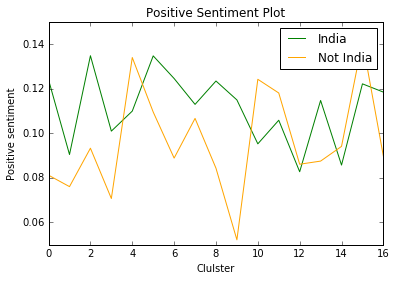

In [149]:
#Plotting the Positive Sentiments

import matplotlib.pyplot as plt

plt.plot(keys, india_pos, color='g',label="India")
plt.plot(keys, not_india_pos, color='orange',label="Not India")
plt.xlabel('Clulster')
plt.ylabel('Positive sentiment')
plt.title('Positive Sentiment Plot')
# showing legend
plt.legend()
plt.show()

# As we can see, in the Positive Sentiment Plot, in general the Indian articles tend to have a more positive sentiment and in the Negative Sentiment Plot, the Indian articles tend to have a less negative sentiment when compared to the non Indian articles for the same cluster.

In [150]:
#Getting the differences in the sentiments, in order to analyze and plot it. 

diff_pos=[]
diff_neg=[]
avg_pos=[]
avg_neg=[]
for i in range(len(india_pos)):
    diff_pos.append(abs(india_pos[i]-not_india_pos[i]))
    diff_neg.append(abs(india_neg[i]-not_india_neg[i]))
    avg_pos.append(abs((india_pos[i]+not_india_pos[i])/2))
    avg_neg.append(abs((india_neg[i]+not_india_neg[i])/2))
print(diff_pos)
print(diff_neg)
print(avg_pos)
print(avg_neg)

[0.042698939014202145, 0.014384103292540765, 0.04143123301267369, 0.030189881647448083, 0.02400364351272534, 0.025154976625353348, 0.035654040404040396, 0.006275757575757615, 0.03906816688023727, 0.06267832167832169, 0.028914397715061116, 0.012209288499025361, 0.0033768542394522205, 0.027180014723307402, 0.008367103446036653, 0.01909057231588286, 0.028706198686371087]
[0.023662951079248512, 0.01159239576395825, 0.024374076958314252, 0.0392775891684217, 0.03003608080558432, 0.021929775494672763, 0.004661616161616158, 0.08502045454545457, 0.058813455611116616, 0.02880769230769231, 0.012204986998868579, 0.0001794649122806996, 0.010131583459466992, 0.02056110671171646, 0.015449135304847164, 0.0023347086660751235, 0.03947104885057471]
[0.10253058061821219, 0.08325367752039628, 0.11399605016032982, 0.08583614891986571, 0.12190420853726844, 0.12206637720156556, 0.1066729797979798, 0.10977121212121213, 0.10384659837806318, 0.08356993006993009, 0.10969053888170391, 0.11190982943469786, 0.084411

# Now, we plot the difference in positive and negative sentiments for all the clusters.

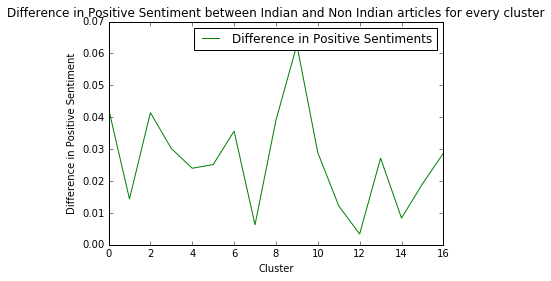

In [151]:
plt.plot(keys, diff_pos, color='g',label="Difference in Positive Sentiments")
plt.xlabel('Cluster')
plt.ylabel('Difference in Positive Sentiment')
plt.title('Difference in Positive Sentiment between Indian and Non Indian articles for every cluster')
# showing legend
plt.legend()
plt.show()

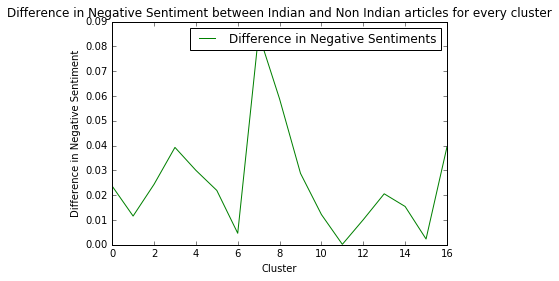

In [152]:
plt.plot(keys, diff_neg, color='g',label="Difference in Negative Sentiments")
plt.xlabel('Cluster')
plt.ylabel('Difference in Negative Sentiment')
plt.title('Difference in Negative Sentiment between Indian and Non Indian articles for every cluster')
# showing legend
plt.legend()
plt.show()

In [153]:
#Getting the Ratio in order to analyze and plot it. 

diff_pos_ratio=[]
diff_neg_ratio=[]
for i in range(len(diff_pos)):
    diff_pos_ratio.append(diff_pos[i]/avg_pos[i])
    diff_neg_ratio.append(diff_neg[i]/avg_neg[i])
print(diff_pos_ratio)
print(diff_neg_ratio)

[0.41645076772946377, 0.17277438932372458, 0.36344446105284095, 0.3517152391777564, 0.19690578201315312, 0.2060762119925578, 0.3342368467775344, 0.057171251501056265, 0.37621036692994014, 0.7500104598133969, 0.2635997416900644, 0.10909933971572873, 0.04000472086005186, 0.26887328844097896, 0.09306182953309347, 0.14500485215276937, 0.27585884504525854]
[0.47257460738300977, 0.19217864853738398, 0.7746728125422141, 0.7648109960292941, 0.6843707431733267, 0.883536817898721, 0.12579216354344114, 0.794659642489193, 0.7941172056314915, 2.0, 0.3918839707980429, 0.005541246589535864, 0.12949161736367926, 0.35371794263509737, 0.2869660396608414, 0.05215203580507654, 0.725578576052193]


# Now, we divide each difference in sentiment by the average sentiment of the cluster for both the positive and negative scores and then plot the graphs.

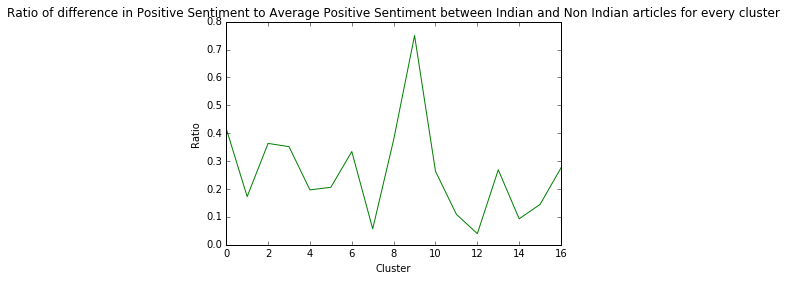

In [157]:
plt.plot(keys, diff_pos_ratio, color='g',label="Ratio of difference in Positive Sentiment to Average Positive Sentiment")
plt.xlabel('Cluster')
plt.ylabel('Ratio')
plt.title('Ratio of difference in Positive Sentiment to Average Positive Sentiment between Indian and Non Indian articles for every cluster')
plt.show()

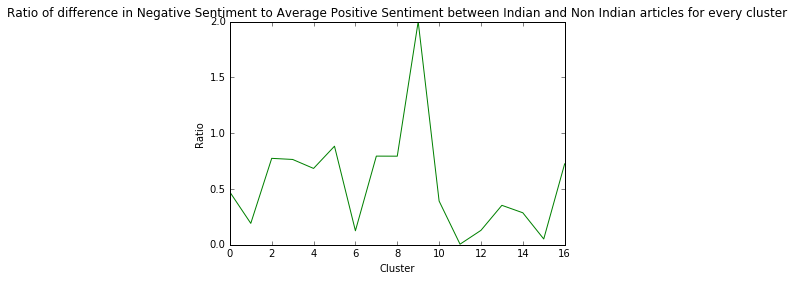

In [158]:
plt.plot(keys, diff_neg_ratio, color='g',label="Ratio of difference in Negative Sentiment to Average Positive Sentiment")
plt.xlabel('Cluster')
plt.ylabel('Ratio')
plt.title('Ratio of difference in Negative Sentiment to Average Positive Sentiment between Indian and Non Indian articles for every cluster')
plt.show()

# Hence, from all the above graphs, there is enough evidence to conclude that there is some bias in the reporting when it comes to India US relations. Although the scores generated by the Vader Sentiment for both positive scores and negative scores are low (below 0.2), we can also see that the neutral scores for every single article is very high. This indicates that the media tends to report news in as neutral a manner as possible and any bias detection is restricted to the small portions of the article which are not neutral. In this small range, we see that the difference in bias in general is significant, and when the ratio of this difference in bias to the average positive/negative score for a cluster is taken, for most clusters, the values are above at least 0.2, and go even above 1 in some cases, and this is a sureshot indicator of bias in the cluster. 